In [90]:
from nbsr.main import run, generate_results
from nbsr.nbsr_config import NBSRConfig

In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from pathlib import Path
import time
import json
import torch

# NBSR workflow

- Specify data locations and covariates in config object.
- Create model object and set up optimizer.
- Run optimization.
- Inference.
- Generate results table and figures.

In [92]:
data_path = Path("data/test/")
X = pd.read_csv(data_path / "X.csv", keep_default_na=False)
Y = pd.read_csv(data_path / "Y.csv")
print(X.shape)
print(Y.shape)
X

(20, 4)
(200, 20)


,sample,trt,lib_size,miRNA_reads
0,Sample1,null,8.335426e+07,5379310
1,Sample2,null,5.417808e+07,840751
2,Sample3,null,8.679085e+06,1661151
3,Sample4,null,8.049912e+06,1924251
4,Sample5,null,2.781898e+07,1091507
5,Sample6,null,5.895722e+07,4657177
6,Sample7,null,8.115881e+07,10154361
7,Sample8,null,2.252620e+07,2820859
8,Sample9,null,3.594308e+06,1555465
9,Sample10,null,5.021435e+07,15256587


# Specifying the model

- We will use `trt` column as the only covariate in the model.
- In the basic model, we will use the shared dispersion parameter $\phi_j$. To do that, we set `trended_dispersion=False`.
- When the number of features in the analysis exceeds 1000, it would greatly speed up inference by using GPU: set `use_cuda_if_available=True`. For small number of features $< 500$, CPU computation is fast enough (in seconds) and in that case, moving the data to GPU might incur some time, which may not be worth it. In this example, we only have 200 features.


In [93]:
input_path = Path("data/test/")
counts_path = input_path / "Y.csv"
cols_path = input_path / "X.csv"
output_path = Path("data/test/output")
x_columns = ["trt"] # list of column names on X to use in fitting NBSR.
# z_columns = None
iterations = 5000
# these default values work fairly well in most settings.
# lr = 0.05
# lam = 1. 
# shape = 3.
# scale = 2.

config = NBSRConfig(counts_path, cols_path, output_path, x_columns, iterations=iterations, 
                    trended_dispersion=False, pivot=True, use_cuda_if_available=False)
config

NBSRConfig(counts_path=PosixPath('data/test/Y.csv'), coldata_path=PosixPath('data/test/X.csv'), output_path=PosixPath('data/test/output'), column_names=['trt'], z_columns=None, lr=0.05, lam=1.0, shape=3.0, scale=2.0, iterations=5000, estimate_dispersion_sd=False, trended_dispersion=False, dispersion_path=None, dispersion_model_path=None, pivot=True, use_cuda_if_available=False)

In [94]:
# Run analysis! 
loss, model = run(config)


Column name trt exists? True
Y:  torch.Size([20, 200])
X:  torch.Size([20, 2])
RNA count: 200
Sample count: 20
Covariate count: 2
beta
phi
psi
Iter: 0
tensor(65473.667230045)
Iter: 100
tensor(34985.191207919)
Iter: 200
tensor(34018.338429599)
Iter: 300
tensor(33744.429025376)
Iter: 400
tensor(33609.880603272)
Iter: 500
tensor(33537.678718056)
Iter: 600
tensor(33477.803097912)
Iter: 700
tensor(33386.936654026)
Iter: 800
tensor(33330.037541486)
Iter: 900
tensor(33292.075963301)
Iter: 1000
tensor(33255.377129181)
Iter: 1100
tensor(33225.958379621)
Iter: 1200
tensor(33207.733608251)
Iter: 1300
tensor(33198.587943221)
Iter: 1400
tensor(33189.835897742)
Iter: 1500
tensor(33181.091389105)
Iter: 1600
tensor(33172.795359892)
Iter: 1700
tensor(33165.928844419)
Iter: 1800
tensor(33159.870737501)
Iter: 1900
tensor(33156.419812985)
Iter: 2000
tensor(33154.159106614)
Iter: 2100
tensor(33152.791534207)
Iter: 2200
tensor(33151.587267565)
Iter: 2300
tensor(33150.559004278)
Iter: 2400
tensor(33149.74062

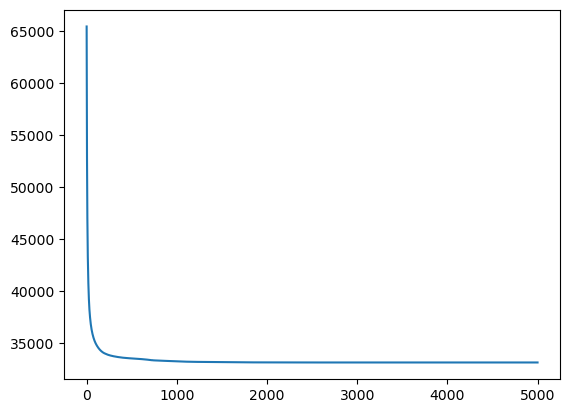

In [95]:
# Plot the loss function.
plt.plot(loss)

In [96]:
# checkpoint file is created by run.
checkpoint_filename = "checkpoint.pth"
checkpoint_file = output_path / checkpoint_filename
os.path.exists(checkpoint_file) # Check that the file exists.

True

# Generate results table

- Typically, when comparing two populations treatment vs control, we want to compare their absolute fold changes. Set `absolute_fc=True`.
- We typically do not need to recompute Hessian as it is computed by `run` function. Set `recompute_hessian=False`.
- Specify the path where the model results are saved and the variable to compare, in this case `trt` and we are comparing `alt` to `null`.

In [97]:
# Generate the results table
res = generate_results(output_path, "trt", "alt", "null", absolute_fc=True, recompute_hessian=False)


Column name trt exists? True
Y:  torch.Size([20, 200])
X:  torch.Size([20, 2])
RNA count: 200
Sample count: 20
Covariate count: 2
beta
phi
psi
Loading previously saved model...
Found covariate trt in the model.


In [98]:
res.head()

,feature,log2FC,pvalue,padj
0,hsa-miR-26a-5p,0.030462,0.964264,0.988717
1,hsa-miR-142-5p,9.572633,0.000000,0.000000
2,hsa-miR-150-5p,-0.027358,0.891279,0.988717
3,hsa-miR-92a-3p,-0.018662,0.927693,0.988717
4,hsa-miR-181a-5p,0.055649,0.943555,0.988717


In [104]:
# Retrieve dispersion phi:
phi = model.softplus(model.phi).detach()


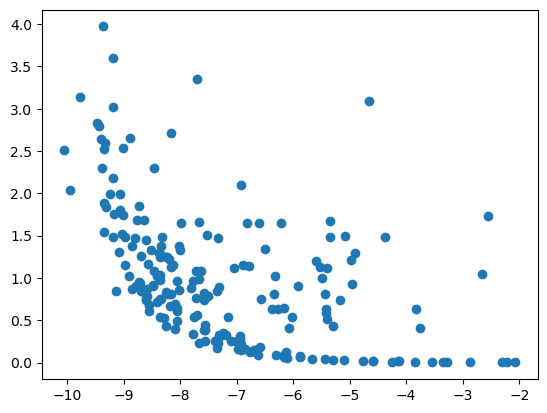

In [106]:
# Generate a plot of \sum_j log(pi_{ij}) vs phi_j:
pi, _ = model.predict(model.beta, model.X)
pi = pi.detach()

plt.scatter(torch.log(pi.mean(0)), phi)

# Trended mean dispersion

We will run analysis on the same dataset using the trended dispersion where the dispersion parameters $\phi_{ij}$ are regulated by Log Normal distribution.

To that end, we will set `trended_dispersion=True` and `estimate_dispersion_sd=True` for mean and `estimate_dispersion_sd=False` for median estimator.

Currently, the dispersion model only includes $\log \pi_{ij}$ and $\log s_i$ as the covariates, where $s_i$ denotes the library size.

In [107]:
input_path = Path("data/test/")
counts_path = input_path / "Y.csv"
cols_path = input_path / "X.csv"
output_path = Path("data/test/output_trended_mean")
x_columns = ["trt"] # list of column names on X to use in fitting NBSR.
# z_columns = None
iterations = 5000
# these default values work fairly well in most settings.
# lr = 0.05
# lam = 1. 
# shape = 3.
# scale = 2.

config = NBSRConfig(counts_path, cols_path, output_path, x_columns, iterations=iterations, 
                    estimate_dispersion_sd=True, trended_dispersion=True, pivot=True, use_cuda_if_available=False)
config

NBSRConfig(counts_path=PosixPath('data/test/Y.csv'), coldata_path=PosixPath('data/test/X.csv'), output_path=PosixPath('data/test/output_trended_mean'), column_names=['trt'], z_columns=None, lr=0.05, lam=1.0, shape=3.0, scale=2.0, iterations=5000, estimate_dispersion_sd=True, trended_dispersion=True, dispersion_path=None, dispersion_model_path=None, pivot=True, use_cuda_if_available=False)

In [108]:
# Run analysis! 
loss, model = run(config)


Column name trt exists? True
Y:  torch.Size([20, 200])
X:  torch.Size([20, 2])
Dispersion trend will be estimated.
RNA count: 200
Sample count: 20
Covariate count: 2
beta
psi
disp_model.b0
disp_model.b1
disp_model.b2
disp_model.kappa
Iter: 0
tensor(45386.939071764)
Iter: 100
tensor(34543.691115942)
Iter: 200
tensor(33348.779180321)
Iter: 300
tensor(32992.565007102)
Iter: 400
tensor(32870.720851467)
Iter: 500
tensor(32771.198149436)
Iter: 600
tensor(32720.785101092)
Iter: 700
tensor(32685.251362974)
Iter: 800
tensor(32649.011936271)
Iter: 900
tensor(32547.127627720)
Iter: 1000
tensor(32510.516214706)
Iter: 1100
tensor(32495.727007469)
Iter: 1200
tensor(32484.603603361)
Iter: 1300
tensor(32475.967168846)
Iter: 1400
tensor(32470.067681729)
Iter: 1500
tensor(32465.699196831)
Iter: 1600
tensor(32462.358956179)
Iter: 1700
tensor(32460.184426721)
Iter: 1800
tensor(32458.404970225)
Iter: 1900
tensor(32457.909397210)
Iter: 2000
tensor(32456.644119245)
Iter: 2100
tensor(32455.516181372)
Iter: 22

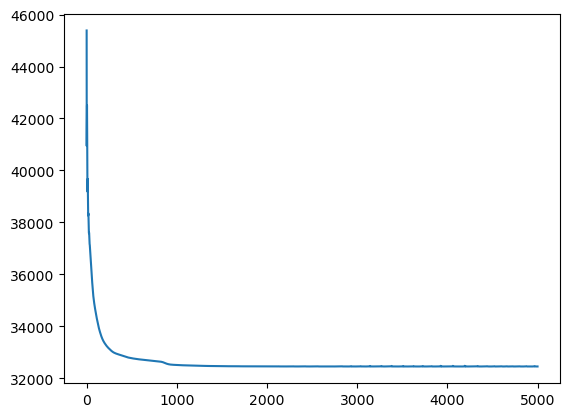

In [109]:
# Plot the loss function.
plt.plot(loss)


In [110]:
# Generate the results table
res2 = generate_results(output_path, "trt", "alt", "null", absolute_fc=True, recompute_hessian=False)


Column name trt exists? True
Y:  torch.Size([20, 200])
X:  torch.Size([20, 2])
Dispersion trend will be estimated.
RNA count: 200
Sample count: 20
Covariate count: 2
beta
psi
disp_model.b0
disp_model.b1
disp_model.b2
disp_model.kappa
Loading previously saved model...
Found covariate trt in the model.


In [111]:
res2.head()

,feature,log2FC,pvalue,padj
0,hsa-miR-26a-5p,0.032301,0.988532,0.997349
1,hsa-miR-142-5p,9.767573,0.000000,0.000000
2,hsa-miR-150-5p,-0.029243,0.587519,0.851476
3,hsa-miR-92a-3p,-0.020328,0.639938,0.865651
4,hsa-miR-181a-5p,0.054731,0.968461,0.988225



- The dispersion can be retrieves by first obtaining $\pi_{ij}$ for each sample, and then pushing it forward on `model.disp_model`.

In [113]:
pi,_ = model.predict(model.beta, model.X)
pi = pi.detach()
phi_trended_mean = torch.exp(model.disp_model.forward(pi)).detach()
phi.shape

torch.Size([20, 200])

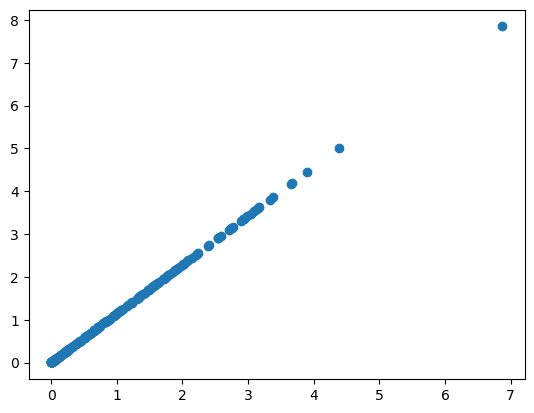

In [114]:
plt.scatter(phi_trended_mean[0,:], phi_trended_mean[1,:]) # Dispersion for samples in the same treatment group differ only in the library size s_i.

In [76]:
# Dispersion estimates for samples from different groups.
sample_idx1 = np.where(X["trt"] == "null")[0][0]
sample_idx2 = np.where(X["trt"] == "alt")[0][0]

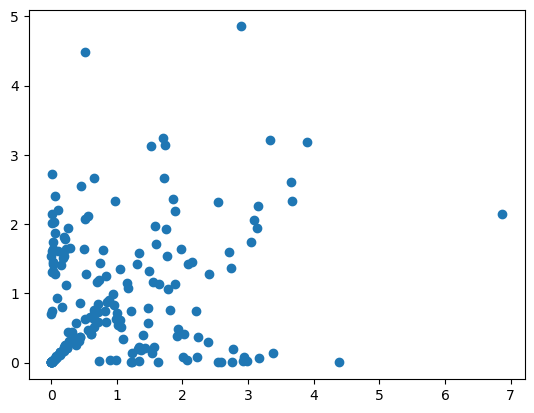

In [115]:
plt.scatter(phi_trended_mean[sample_idx1,:], phi_trended_mean[sample_idx2,:]) 

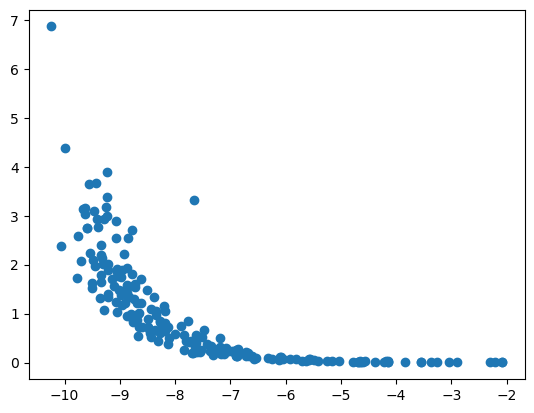

In [116]:
plt.scatter(torch.log(pi[sample_idx1,:]), phi_trended_mean[sample_idx1,:])


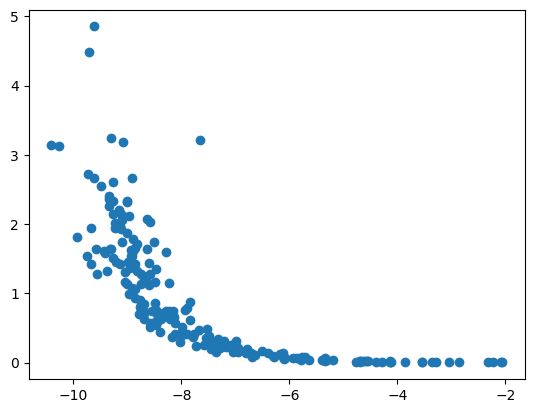

In [117]:
plt.scatter(torch.log(pi[sample_idx2,:]), phi_trended_mean[sample_idx2,:])

## Trended median dispersion

Somewhat more conservative approach to dispersion estimation is to use median of the trend line.

To do so, we set `estimate_dispersion_sd=False`.

In [118]:
input_path = Path("data/test/")
counts_path = input_path / "Y.csv"
cols_path = input_path / "X.csv"
output_path = Path("data/test/output_trended_median")
x_columns = ["trt"] # list of column names on X to use in fitting NBSR.
# z_columns = None
iterations = 5000
# these default values work fairly well in most settings.
# lr = 0.05
# lam = 1. 
# shape = 3.
# scale = 2.

config = NBSRConfig(counts_path, cols_path, output_path, x_columns, iterations=iterations, 
                    estimate_dispersion_sd=False, trended_dispersion=True, pivot=True, use_cuda_if_available=False)
config

NBSRConfig(counts_path=PosixPath('data/test/Y.csv'), coldata_path=PosixPath('data/test/X.csv'), output_path=PosixPath('data/test/output_trended_median'), column_names=['trt'], z_columns=None, lr=0.05, lam=1.0, shape=3.0, scale=2.0, iterations=5000, estimate_dispersion_sd=False, trended_dispersion=True, dispersion_path=None, dispersion_model_path=None, pivot=True, use_cuda_if_available=False)

In [119]:
# Run analysis! 
loss, model = run(config)


Column name trt exists? True
Y:  torch.Size([20, 200])
X:  torch.Size([20, 2])
Dispersion trend will be estimated.
RNA count: 200
Sample count: 20
Covariate count: 2
beta
psi
disp_model.b0
disp_model.b1
disp_model.b2
Iter: 0
tensor(43349.717035584)
Iter: 100
tensor(35388.603148181)
Iter: 200
tensor(33776.262829184)
Iter: 300
tensor(32842.263614953)
Iter: 400
tensor(32763.977379971)
Iter: 500
tensor(32725.586718921)
Iter: 600
tensor(32693.510556061)
Iter: 700
tensor(32665.517771843)
Iter: 800
tensor(32641.629708375)
Iter: 900
tensor(32621.939654293)
Iter: 1000
tensor(32606.189759326)
Iter: 1100
tensor(32594.081982400)
Iter: 1200
tensor(32585.023347709)
Iter: 1300
tensor(32578.906077745)
Iter: 1400
tensor(32573.921419004)
Iter: 1500
tensor(32570.723871752)
Iter: 1600
tensor(32569.097333858)
Iter: 1700
tensor(32567.364802705)
Iter: 1800
tensor(32566.636932267)
Iter: 1900
tensor(32566.119598488)
Iter: 2000
tensor(32566.013702986)
Iter: 2100
tensor(32565.852121260)
Iter: 2200
tensor(32565.6

In [120]:
# Generate the results table
res3 = generate_results(output_path, "trt", "alt", "null", absolute_fc=True, recompute_hessian=False)


Column name trt exists? True
Y:  torch.Size([20, 200])
X:  torch.Size([20, 2])
Dispersion trend will be estimated.
RNA count: 200
Sample count: 20
Covariate count: 2
beta
psi
disp_model.b0
disp_model.b1
disp_model.b2
Loading previously saved model...
Found covariate trt in the model.


In [121]:
res3.head()

,feature,log2FC,pvalue,padj
0,hsa-miR-26a-5p,0.032119,0.983041,0.992971
1,hsa-miR-142-5p,10.361328,0.000000,0.000000
2,hsa-miR-150-5p,-0.027933,0.569901,0.838090
3,hsa-miR-92a-3p,-0.020051,0.638426,0.866380
4,hsa-miR-181a-5p,0.055041,0.971984,0.986786


In [122]:
pi,_ = model.predict(model.beta, model.X)
pi = pi.detach()
phi_trended_median = torch.exp(model.disp_model.forward(pi)).detach()
phi_trended_median.shape

torch.Size([20, 200])

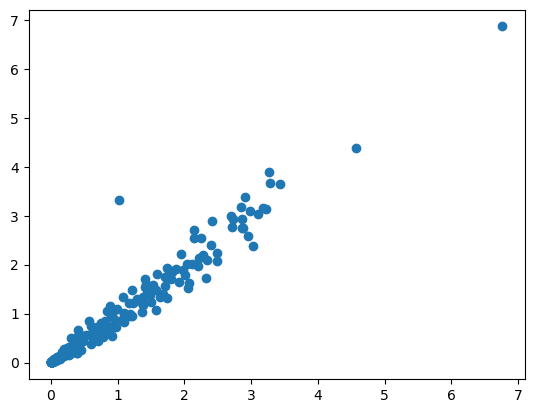

In [123]:
# Compare trended mean vs median
plt.scatter(phi_trended_median[sample_idx1,:], phi_trended_mean[sample_idx1,:])

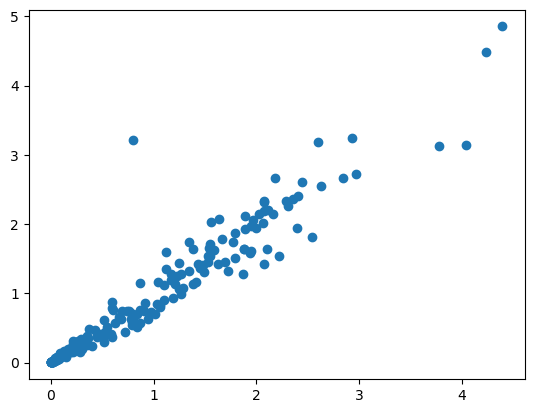

In [124]:
plt.scatter(phi_trended_median[sample_idx2,:], phi_trended_mean[sample_idx2,:])